In [2]:
import pandas as pd
from skimage import io, transform
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torchvision
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Subset
import sys
sys.path.append('/Users/spencerfong/Documents/ADNI Research/MP-Rage Images/3D_Pretrained_Networks')
import resnet
importlib.reload(resnet)
from collections import OrderedDict
from sklearn.manifold import TSNE

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
import pydicom as dicom
import matplotlib.pylab as pylab
from os import listdir, walk, path, getcwd
import re
import time
import xml.etree.ElementTree as ET

from PIL import Image
import requests
from io import BytesIO

import warnings
warnings.filterwarnings("ignore")
import pydicom as dicom
import matplotlib.pylab as plt
from os import listdir, walk, path, makedirs
import pandas as pd
import re
import numpy as np
import sys
import time
import xml.etree.ElementTree as ET


import math
from scipy.ndimage import zoom

In [ ]:
Dataset

In [30]:
import importlib
import Import_classes
importlib.reload(Import_classes)
from os import path, makedirs
import torch
from torch.utils.data import random_split, DataLoader
import numpy as np
#import matplotlib.pyplot as plt

Okay so my goal is to achieve a grid layout where I have the importances on each like nine areas marked, overlayed like a heat map. I won't worry about different slices yet, just focus on getting the form/results out for further evaluation or changing.

In [1]:
dim_reduction_dir = 'Testing big download/'

In [5]:
transforms = Import_classes.NormalizeMatrix()

In [6]:
# Path to your CSV file
csv_file_2d = path.join(dim_reduction_dir,'ADNI/training_loop.csv')

# Create the dataset
dataset_2d = Import_classes.Rage_Scans(csv_file=csv_file_2d,transform=transforms)

In [12]:
# create a training, testing, and validation sets
torch.manual_seed(42)
train_size = int(0.66 * len(dataset_2d))
val_size = int(0.17 * len(dataset_2d))
test_size = len(dataset_2d) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_2d, [train_size, val_size, test_size])

In [15]:
dataloader_2d_test = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [23]:
torch.tensor(dataset_2d.__getitem__(0)['matrix']).shape

torch.Size([256, 256])

In [38]:
one_slice_unfolded = torch.tensor(
    dataset_2d.__getitem__(0)['matrix'])\
.unfold(0, 25, 25).unfold(1,25,25)

In [39]:
one_slice_unfolded.shape

torch.Size([10, 10, 25, 25])

In [48]:
reverted = one_slice_unfolded.permute(0, 2, 1, 3).contiguous().view(250, 250)
(np.array(reverted) == play_matrix[0:250,0:250])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

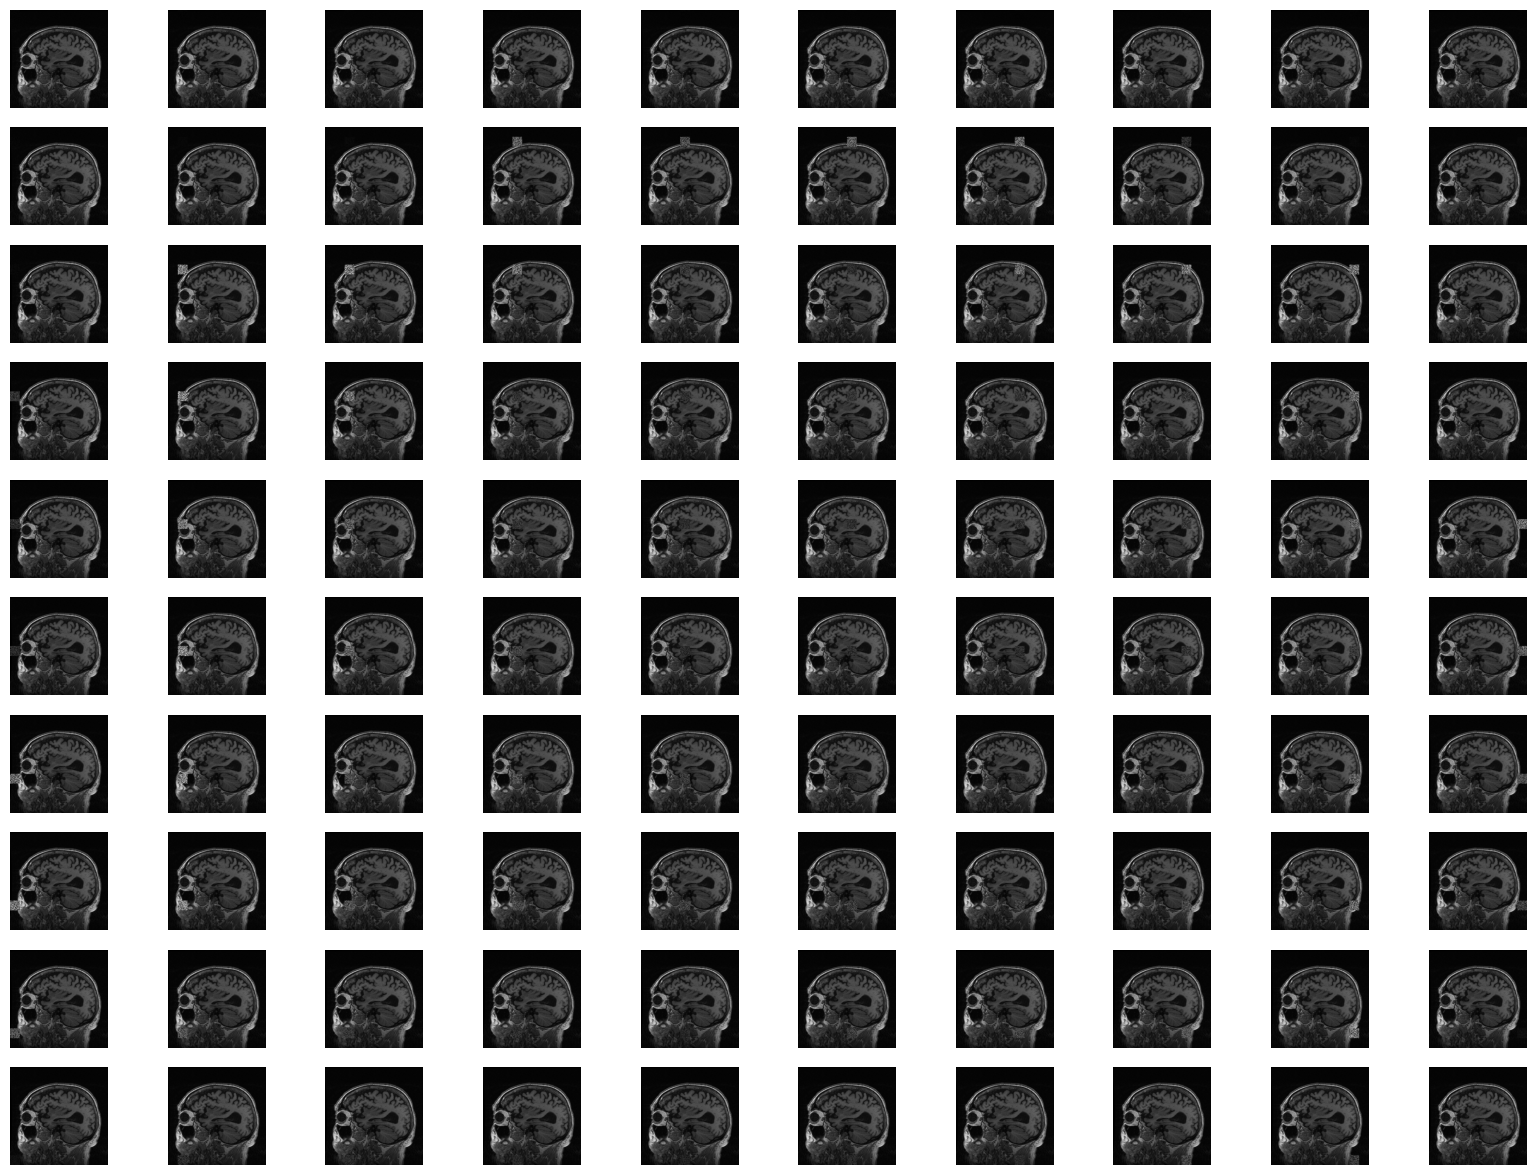

In [218]:
plt.figure(figsize=(20,15))
for i in range(100):
    image = all_windowed_images[i]
    plt.subplot(10,10,i+1)
    plt.imshow(image,cmap='gray')
    plt.axis('off')

In [11]:
# get all images in test_dataset
test_images = []
for i in range(len(test_dataset)):
    test_images.append(test_dataset.__getitem__(i)['matrix'])

In [41]:
def window_and_fold(unfolded_image):
    all_windowed_images = []
    length = len(unfolded_image)
    for i in range(length):
        for j in range(length):
            save_window = unfolded_image[i][j].clone()
            for x in range(len(unfolded_image[i][j])):
                for y in range(len(unfolded_image[i][j])):
                    unfolded_image[i][j][x][y] = \
                    np.random.uniform(unfolded_image[i][j].min()
                                      , unfolded_image[i][j].max())
            reverted = unfolded_image.permute(0, 2, 1, 3) \
            .contiguous().view(250, 250)
            all_windowed_images.append(reverted)
            unfolded_image[i][j] = save_window
    return all_windowed_images

In [18]:
n=0
full_windowed_test_set = []
for image in test_images:
    unfolded_image = torch.tensor(image).unfold(0, 25, 25).unfold(1,25,25)
    full_windowed_test_set.append(window_and_fold(unfolded_image))
    n+=1
    if n%10==0:
        print(n)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410


In [20]:
len(full_windowed_test_set)

1411

In [75]:
for i in range(len(test_dataset.indices)):
    dir_path = path.join('Pixel_Importance/' + dataset_2d.data_frame.loc[test_dataset.indices].reset_index(drop=True)['File Path'][i])
    if not path.exists(dir_path):
        makedirs(dir_path)

In [76]:
length = len(test_dataset.indices)
for i in range(length):
    for j in range(100):
        np.save(
            path.join('Pixel_Importance/' + 
                          dataset_2d.data_frame.loc[test_dataset.indices]\
                          .reset_index(drop=True)['File Path'][i] + 
                          '/' + 'window_' + f'{j+1}'), \
                          full_windowed_test_set[i][j])

Okay, I might have to pad and re-do everything. But before doing that, we're just gonna get it all set up to actually run and get the losses

In [3]:
pattern = re.compile(r'window_')

def create_csv(directory1):#, directory2):
    paths = []
    groups = []
    for root, dirs, files in walk(directory1):
        for name in files:
            if name == '.DS_Store':
                continue
            if re.search(pattern, name):
                paths.append(path.join(root, name))
    return paths

In [4]:
x = create_csv('Pixel_Importance/')

In [5]:
x[0]

'Pixel_Importance/Testing big download/ADNI/002_S_0782/MP-RAGE/2006-08-14_09_39_47.0/I20519_Pixel_Matrices/ADNI_002_S_0782_MR_MP-RAGE__br_raw_20060814234013189_85_S17835_I20519_pm.npy/window_53.npy'

In [12]:
get_labels_df = dataset_2d.data_frame.loc[test_dataset.indices]

In [13]:
get_labels_df['File Path'][get_labels_df['File Path'].str.contains('85_S17835_I20519')].index

Index([846], dtype='int64')

In [14]:
get_labels_df.loc[get_labels_df['File Path'][get_labels_df['File Path'].str.contains('85_S17835_I20519')].index]['Research Group']

846    1
Name: Research Group, dtype: int64

In [179]:
pattern = re.compile(r'\d{1,3}_[a-zA-Z0-9]+_I\d{5,7}')
labels = []

for path in x:
    new_pattern = re.search(pattern, path).group(0)
    label = get_labels_df.loc[get_labels_df['File Path']\
    [get_labels_df['File Path'].str.contains(new_pattern)]\
    .index]['Research Group'].iloc[0]
    labels.append(label)

In [181]:
pd.Series(labels).value_counts()

0    65300
1    45500
2    30300
Name: count, dtype: int64

In [182]:
pi_df = pd.DataFrame({'File Path':x, 'Research Group':labels})
pi_df.to_csv('Pixel_Importance/pixel_importance_windows.csv',index=False)

In [183]:
pi_df

,File Path,Research Group
0,Pixel_Importance/Testing big download/ADNI/002...,1
1,Pixel_Importance/Testing big download/ADNI/002...,1
2,Pixel_Importance/Testing big download/ADNI/002...,1
3,Pixel_Importance/Testing big download/ADNI/002...,1
4,Pixel_Importance/Testing big download/ADNI/002...,1
...,...,...
141095,Pixel_Importance/Testing big download/ADNI/002...,0
141096,Pixel_Importance/Testing big download/ADNI/002...,0
141097,Pixel_Importance/Testing big download/ADNI/002...,0
141098,Pixel_Importance/Testing big download/ADNI/002...,0


In [121]:
# load in pretrained resnet50
resnet50 = models.resnet50(pretrained=True)
# set the first layer to accept 1 channel (grayscale) instead of 3. Not super sure of all the details going on.
original_conv1 = resnet50.conv1
resnet50.conv1 = nn.Conv2d(1, original_conv1.out_channels, kernel_size=original_conv1.kernel_size,
                           stride=original_conv1.stride, padding=original_conv1.padding, bias=False)

with torch.no_grad():
    resnet50.conv1.weight = nn.Parameter(original_conv1.weight.sum(dim=1, keepdim=True))

# set device
device = 'cpu'

# set number of classes to 3
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 3)

resnet50.load_state_dict(torch.load('Models/tbd_normalized_2d.pth'))

<All keys matched successfully>

In [122]:
resnet50_tbd_normalized = resnet50

In [133]:
dataloader_2d_test = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [157]:
og_losses = []
total_samples = 0
total_correct = 0
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
    for i, batch in enumerate(dataloader_2d_test):
        matrix = batch['matrix']
        labels = batch['label']
        matrix = torch.unsqueeze(matrix, 1)
        outputs = resnet50_tbd_normalized(matrix)
        loss = criterion(outputs, labels)
        og_losses.append(loss)
        if i % 200 == 199:
            print(f'Step {i+1} / {len(dataloader_2d_test)}')

Step 200 / 1411
Step 400 / 1411
Step 600 / 1411
Step 800 / 1411
Step 1000 / 1411
Step 1200 / 1411
Step 1400 / 1411


In [23]:
og_paths = list(dataset_2d.data_frame.loc[test_dataset.indices]['File Path'])
og_infos_df = pd.DataFrame({'File Path':og_paths, 'Loss':og_losses})
og_infos_df.to_csv('Pixel_Importance/og_infos.csv',index=False)

NameError: name 'dataset_2d' is not defined

Okay now things get serious. I'm gonna create a dataset based on pixel_importance_windows.csv. Then I will pass each one through individually, save the loss and then use regex to find the corresponding original image and compare to the windowed image loss.

In [188]:
windows_csv = 'Pixel_Importance/pixel_importance_windows.csv'

transforms = Import_classes.pad_250_256()

windows_dataset = Import_classes.Rage_Scans(csv_file=windows_csv, transform=transforms)

windows_dataloader = DataLoader(windows_dataset, batch_size=1, shuffle=False)

In [203]:
windows_loss = []
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
    for i, batch in enumerate(windows_dataloader):
        matrix = batch['matrix']
        labels = batch['label']
        matrix = torch.unsqueeze(matrix, 1)
        outputs = resnet50_tbd_normalized(matrix)
        loss = criterion(outputs, labels)
        windows_loss.append(loss)
        if i % 10000 == 9999:
            print(f'Step {i+1} / {len(windows_dataloader)}')

Step 10000 / 141100
Step 20000 / 141100
Step 30000 / 141100
Step 40000 / 141100
Step 50000 / 141100
Step 60000 / 141100
Step 70000 / 141100
Step 80000 / 141100
Step 90000 / 141100
Step 100000 / 141100
Step 110000 / 141100
Step 120000 / 141100
Step 130000 / 141100
Step 140000 / 141100


In [212]:
len(windows_loss)
len(og_losses)

1411

In [214]:
pi_df['Loss'] = windows_loss

In [236]:
pi_df['File Path'][1]

'Pixel_Importance/Testing big download/ADNI/002_S_0782/MP-RAGE/2006-08-14_09_39_47.0/I20519_Pixel_Matrices/ADNI_002_S_0782_MR_MP-RAGE__br_raw_20060814234013189_85_S17835_I20519_pm.npy/window_47.npy'

In [222]:
pattern = re.compile(r'\d{1,3}_[a-zA-Z0-9]+_I\d{5,7}')
unique_ids = []
for path in pi_df['File Path']:
    i_d = re.search(pattern, path).group(0)
    unique_ids.append(i_d)

In [225]:
pi_df['Unique ID'] = unique_ids

In [239]:
pattern = re.compile(r'window_(\d{1,3})')
windows = []
for path in pi_df['File Path']:
    window = re.search(pattern, path).group(1)
    windows.append(int(window))

In [246]:
pi_df['Window'] = windows

In [247]:
#pi_df.to_csv('Pixel_Importance/pixel_importance_fulldata.csv',index=False)

In [250]:
pattern = re.compile(r'\d{1,3}_[a-zA-Z0-9]+_I\d{5,7}')
unique_ids = []
for path in og_infos_df['File Path']:
    i_d = re.search(pattern, path).group(0)
    unique_ids.append(i_d)
og_infos_df['Unique ID'] = unique_ids

In [384]:
uid = og_infos_df['Unique ID'][6]

In [385]:
pi_df[pi_df['Unique ID'] == uid][['Loss','Window']]

,Loss,Window
128300,tensor(1.0687),53
128301,tensor(1.0026),47
128302,tensor(1.0614),90
128303,tensor(1.0476),84
128304,tensor(1.0453),85
...,...,...
128395,tensor(1.0547),88
128396,tensor(1.0562),2
128397,tensor(1.0380),89
128398,tensor(1.0767),62


In [313]:
#list(pi_df[pi_df['Unique ID'] == uid]['Window'])

In [476]:
uid = og_infos_df['Unique ID'][0]

In [477]:
x = pd.DataFrame({uid:[float(og_infos_df[og_infos_df['Unique ID'] == uid]['Loss']) - float(loss) for loss in pi_df[pi_df['Unique ID'] == uid]['Loss']], 'Window':list(pi_df[pi_df['Unique ID'] == uid]['Window'])})

In [478]:
x

,45_S19978_I26138,Window
0,0.065387,53
1,0.045891,47
2,0.065214,90
3,-0.029601,84
4,0.031284,85
...,...,...
95,0.080071,88
96,0.080272,2
97,0.040577,89
98,0.071064,62


In [482]:
loss_calc_df = (x.sort_values('Window')
                .set_index('Window')
                .reset_index(drop=True)
                .T
                .rename(columns=lambda x: f'window_{x}')
                .rename_axis('UID', axis='index'))

In [480]:
loss_calc_df

,window_0,window_1,window_2,window_3,window_4,window_5,window_6,window_7,window_8,window_9,...,window_90,window_91,window_92,window_93,window_94,window_95,window_96,window_97,window_98,window_99
UID,,,,,,,,,,,,,,,,,,,,,
45_S19978_I26138,0.051993,0.080272,0.078139,0.082671,0.039686,0.044996,0.066934,0.071193,0.096013,0.068301,...,0.077349,0.059249,0.077306,0.050893,0.090476,0.056604,0.068026,0.101367,0.067721,0.091991


In [474]:
pd.concat([loss_calc_df, loss_calc_df2])

,window_0,window_1,window_2,window_3,window_4,window_5,window_6,window_7,window_8,window_9,...,window_90,window_91,window_92,window_93,window_94,window_95,window_96,window_97,window_98,window_99
UID,,,,,,,,,,,,,,,,,,,,,
45_S19978_I26138,0.051993,0.080272,0.078139,0.082671,0.039686,0.044996,0.066934,0.071193,0.096013,0.068301,...,0.077349,0.059249,0.077306,0.050893,0.090476,0.056604,0.068026,0.101367,0.067721,0.091991
102_S54591_I114997,-0.044948,-0.037758,-0.048070,-0.056668,-0.068390,-0.057305,-0.061379,-0.059712,-0.065221,-0.063535,...,-0.057862,-0.074177,-0.069724,-0.047987,-0.026256,-0.039095,-0.079817,-0.074429,-0.061737,-0.059311


In [483]:
for uid in og_infos_df['Unique ID']:
    df = pd.DataFrame({uid:[float(og_infos_df[og_infos_df['Unique ID'] == \
                                  uid]['Loss']) - float(loss) for loss in pi_df[pi_df['Unique ID'] == \
                            uid]['Loss']], 'Window':list(pi_df[pi_df['Unique ID'] == uid]['Window'])})
    df = (df.sort_values('Window')
          .set_index('Window')
          .reset_index(drop=True)
          .T
          .rename(columns=lambda x: f'window_{x}')
          .rename_axis('UID', axis='index'))
    loss_calc_df = pd.concat([loss_calc_df, df])

In [485]:
#loss_calc_df.to_csv('Pixel_Importance/pixel_importance_loss_calc.csv')

In [4]:
loss_calc_df = pd.read_csv('Pixel_Importance/pixel_importance_loss_calc.csv')

In [5]:
loss_calc_df = loss_calc_df.drop(1).reset_index(drop=True)

In [6]:
window_cols = list(loss_calc_df.columns)
window_cols.remove('UID')

In [7]:
full_heat_map = np.reshape(np.array([loss_calc_df[col].sum() for col in loss_calc_df[window_cols]]), (10,10))

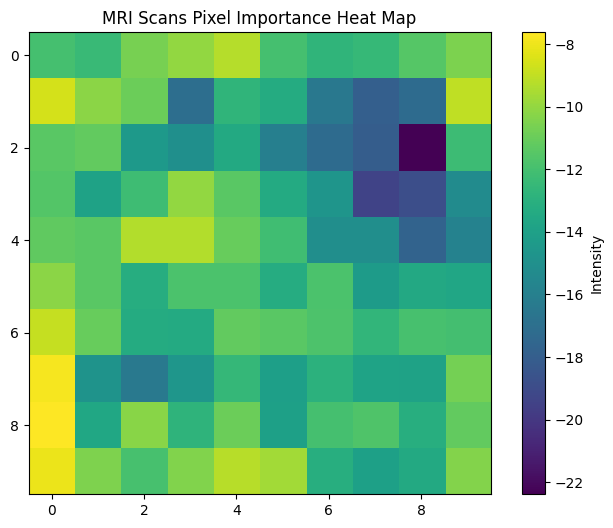

In [12]:
# Create the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(full_heat_map, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Intensity')
plt.title('MRI Scans Pixel Importance Heat Map')
plt.savefig('All_images_heat.png')
plt.show()

In [14]:
nums = np.random.randint(0,1411,5)
nums

array([694, 593, 294, 789,  45])

In [15]:
loss_calc_df.loc[222]

UID          73_S38908_I71849
window_0             0.041731
window_1             0.056119
window_2             0.043121
window_3             0.047359
                   ...       
window_95            0.087276
window_96             0.06561
window_97            0.055621
window_98            0.032666
window_99            0.016394
Name: 222, Length: 101, dtype: object

In [19]:
cmap = plt.get_cmap('viridis')

In [21]:
image_222 = np.reshape(np.array([num for num in loss_calc_df.loc[222][window_cols]]), (10,10))
normalized_data = (image_222 - np.min(image_222)) / (np.max(image_222) - np.min(image_222))
rgb_values = cmap(normalized_data)[:, :, :3]

In [25]:
#og_infos_df = pd.read_csv('Pixel_Importance/og_infos.csv')
og_infos_df.loc[222]['File Path']

'Testing big download/ADNI/002_S_0729/MP-RAGE/2007-09-05_06_40_34.0/I71849_Pixel_Matrices/ADNI_002_S_0729_MR_MP-RAGE__br_raw_20070905153649145_73_S38908_I71849_pm.npy'

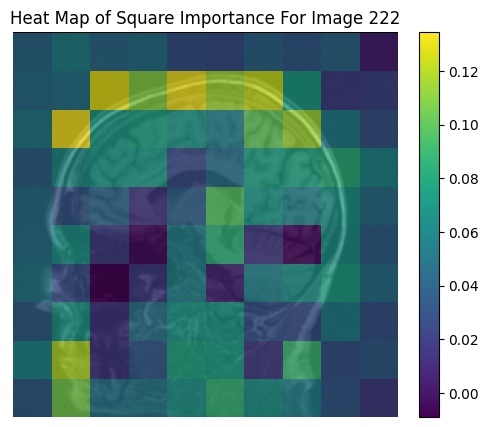

In [54]:
# Load the grayscale image
plt.figure(figsize=(7, 5))
path_222 = og_infos_df.loc[222]['File Path']
image_path = path_222
slice_222 = np.load(image_path)[:250, :250]

# Display the grayscale image
im = plt.imshow(slice_222, cmap='gray')
plt.axis('off')

# Set the size of the squares
square_size = 25
num_squares = 10  # 10 squares in total
# Loop to create and fill squares
for i in range(num_squares):
    for j in range(num_squares):
        # Create a rectangle (patch) for each square
        rect = patches.Rectangle((i * square_size, j * square_size), 
                                 square_size, square_size,
                                 linewidth=0,  # No border
                                 edgecolor='none', 
                                 facecolor=(rgb_values[j][i],.7))  # Solid fill color
        plt.gca().add_patch(rect)

plt.title('Heat Map of Square Importance For Image 222')


cmap = plt.cm.viridis

# Normalize the original rgb_values for color mapping
norm = mcolors.Normalize(vmin=np.min(image_222), vmax=np.max(image_222))

mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
#mappable.set_array([])  # Set array to an empty list for colorbar
plt.colorbar(mappable, ax=plt.gca(), orientation='vertical', fraction=0.046, pad=0.04)

plt.show()

In [212]:
#nums = np.random.randint(0,1411,5)
nums

array([ 222, 1115, 1313,  965,   10])

In [57]:
loss_calc_df.loc[1115]

UID          156_S39495_I73815
window_0              0.102623
window_1              0.049418
window_2              0.026425
window_3              0.043966
                   ...        
window_95             0.072333
window_96            -0.009026
window_97             -0.02737
window_98            -0.091673
window_99             0.023284
Name: 1115, Length: 101, dtype: object

In [58]:
image_1115 = np.reshape(np.array([num for num in loss_calc_df.loc[1115][window_cols]]), (10,10))
normalized_data = (image_1115 - np.min(image_1115)) / (np.max(image_1115) - np.min(image_1115))
rgb_values = cmap(normalized_data)[:, :, :3]

In [59]:
#og_infos_df = pd.read_csv('Pixel_Importance/og_infos.csv')
og_infos_df.loc[1115]['File Path']

'Testing big download/ADNI/002_S_0782/MP-RAGE/2007-09-19_06_40_17.0/I73815_Pixel_Matrices/ADNI_002_S_0782_MR_MP-RAGE__br_raw_20070919210813930_156_S39495_I73815_pm.npy'

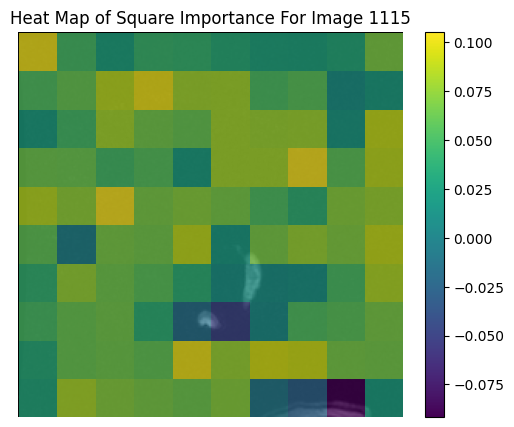

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the grayscale image
plt.figure(figsize=(7, 5))
path_1115 = og_infos_df.loc[1115]['File Path']
image_path = path_1115
slice_1115 = np.load(image_path)[:250, :250]

# Display the grayscale image
plt.imshow(slice_1115, cmap='gray')
plt.axis('off')

# Set the size of the squares
square_size = 25
num_squares = 10  # 10 squares in total
# Loop to create and fill squares
for i in range(num_squares):
    for j in range(num_squares):
        # Create a rectangle (patch) for each square
        rect = patches.Rectangle((i * square_size, j * square_size), 
                                 square_size, square_size,
                                 linewidth=0,  # No border
                                 edgecolor='none', 
                                 facecolor=(rgb_values[j][i],.7))  # Solid fill color
        plt.gca().add_patch(rect)

plt.title('Heat Map of Square Importance For Image 1115')
cmap = plt.cm.viridis

# Normalize the original rgb_values for color mapping
norm = mcolors.Normalize(vmin=np.min(image_1115), vmax=np.max(image_1115))

mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
#mappable.set_array([])  # Set array to an empty list for colorbar
plt.colorbar(mappable, ax=plt.gca(), orientation='vertical', fraction=0.046, pad=0.04)
plt.show()

In [212]:
#nums = np.random.randint(0,1411,5)
nums

array([ 222, 1115, 1313,  965,   10])

In [74]:
loss_calc_df.loc[1313]

UID          147_S69298_I147113
window_0               0.029911
window_1               0.032203
window_2               0.006731
window_3               0.017248
                    ...        
window_95              0.046841
window_96              0.047374
window_97              0.043351
window_98              0.042737
window_99              0.019826
Name: 1313, Length: 101, dtype: object

In [75]:
image_1313 = np.reshape(np.array([num for num in loss_calc_df.loc[1313][window_cols]]), (10,10))
normalized_data = (image_1313 - np.min(image_1313)) / (np.max(image_1313) - np.min(image_1313))
rgb_values = cmap(normalized_data)[:, :, :3]

In [76]:
#og_infos_df = pd.read_csv('Pixel_Importance/og_infos.csv')
og_infos_df.loc[1313]['File Path']

'Testing big download/ADNI/002_S_0559/MP-RAGE/2009-06-30_17_19_02.0/I147113_Pixel_Matrices/ADNI_002_S_0559_MR_MP-RAGE__br_raw_20090701011419758_147_S69298_I147113_pm.npy'

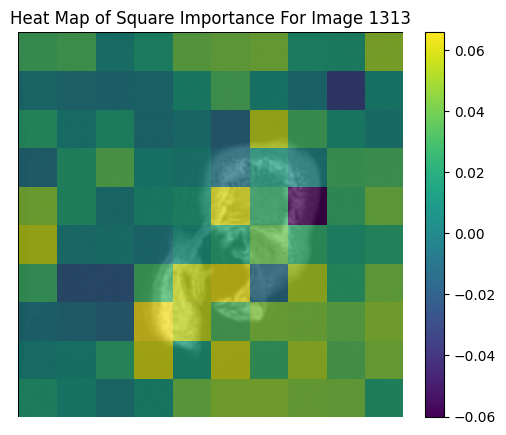

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the grayscale image
plt.figure(figsize=(7, 5))
path_1313 = og_infos_df.loc[1313]['File Path']
image_path = path_1313
slice_1313 = np.load(image_path)[:250, :250]

# Display the grayscale image
plt.imshow(slice_1313, cmap='gray')
plt.axis('off')

# Set the size of the squares
square_size = 25
num_squares = 10  # 10 squares in total
# Loop to create and fill squares
for i in range(num_squares):
    for j in range(num_squares):
        # Create a rectangle (patch) for each square
        rect = patches.Rectangle((i * square_size, j * square_size), 
                                 square_size, square_size,
                                 linewidth=0,  # No border
                                 edgecolor='none', 
                                 facecolor=(rgb_values[j][i],.7))  # Solid fill color
        plt.gca().add_patch(rect)

plt.title('Heat Map of Square Importance For Image 1313')
cmap = plt.cm.viridis

# Normalize the original rgb_values for color mapping
norm = mcolors.Normalize(vmin=np.min(image_1313), vmax=np.max(image_1313))

mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
#mappable.set_array([])  # Set array to an empty list for colorbar
plt.colorbar(mappable, ax=plt.gca(), orientation='vertical', fraction=0.046, pad=0.04)
plt.show()

In [212]:
#nums = np.random.randint(0,1411,5)
nums

array([ 222, 1115, 1313,  965,   10])

In [88]:
loss_calc_df.loc[965]

UID          143_S13893_I14437
window_0              0.097774
window_1              0.071302
window_2               0.07655
window_3              0.088766
                   ...        
window_95             0.073211
window_96             0.084152
window_97              0.08047
window_98             0.059582
window_99             0.067012
Name: 965, Length: 101, dtype: object

In [89]:
image_965 = np.reshape(np.array([num for num in loss_calc_df.loc[965][window_cols]]), (10,10))
normalized_data = (image_965 - np.min(image_965)) / (np.max(image_965) - np.min(image_965))
rgb_values = cmap(normalized_data)[:, :, :3]

In [90]:
#og_infos_df = pd.read_csv('Pixel_Importance/og_infos.csv')
og_infos_df.loc[965]['File Path']

'Testing big download/ADNI/002_S_0413/MP-RAGE/2006-05-02_12_31_52.0/I14437_Pixel_Matrices/ADNI_002_S_0413_MR_MP-RAGE__br_raw_20060502143110974_143_S13893_I14437_pm.npy'

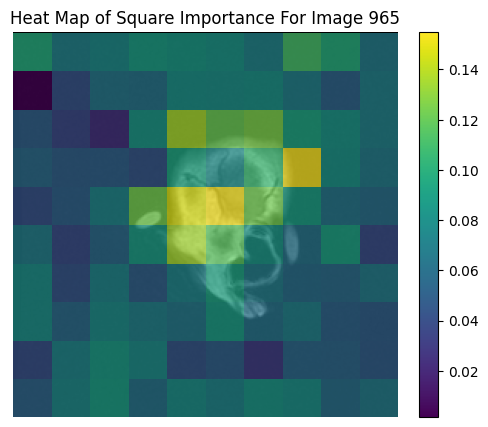

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the grayscale image
plt.figure(figsize=(7, 5))
path_965 = og_infos_df.loc[965]['File Path']
image_path = path_965
slice_965 = np.load(image_path)[:250, :250]

# Display the grayscale image
plt.imshow(slice_965, cmap='gray')
plt.axis('off')

# Set the size of the squares
square_size = 25
num_squares = 10  # 10 squares in total
# Loop to create and fill squares
for i in range(num_squares):
    for j in range(num_squares):
        # Create a rectangle (patch) for each square
        rect = patches.Rectangle((i * square_size, j * square_size), 
                                 square_size, square_size,
                                 linewidth=0,  # No border
                                 edgecolor='none', 
                                 facecolor=(rgb_values[j][i],.7))  # Solid fill color
        plt.gca().add_patch(rect)

plt.title('Heat Map of Square Importance For Image 965')
cmap = plt.cm.viridis

# Normalize the original rgb_values for color mapping
norm = mcolors.Normalize(vmin=np.min(image_965), vmax=np.max(image_965))

mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(mappable, ax=plt.gca(), orientation='vertical', fraction=0.046, pad=0.04)
plt.show()

In [212]:
#nums = np.random.randint(0,1411,5)
nums

array([ 222, 1115, 1313,  965,   10])

In [93]:
loss_calc_df.loc[10]

UID          58_S32678_I55275
window_0            -0.023578
window_1            -0.017954
window_2            -0.032954
window_3             -0.02115
                   ...       
window_95           -0.040043
window_96           -0.011203
window_97           -0.027658
window_98           -0.017229
window_99           -0.013271
Name: 10, Length: 101, dtype: object

In [94]:
image_10 = np.reshape(np.array([num for num in loss_calc_df.loc[10][window_cols]]), (10,10))
normalized_data = (image_10 - np.min(image_10)) / (np.max(image_10) - np.min(image_10))
rgb_values = cmap(normalized_data)[:, :, :3]

In [95]:
#og_infos_df = pd.read_csv('Pixel_Importance/og_infos.csv')
og_infos_df.loc[10]['File Path']

'Testing big download/ADNI/002_S_0295/MP-RAGE/2007-05-25_07_12_36.0/I55275_Pixel_Matrices/ADNI_002_S_0295_MR_MP-RAGE__br_raw_20070525135731959_58_S32678_I55275_pm.npy'

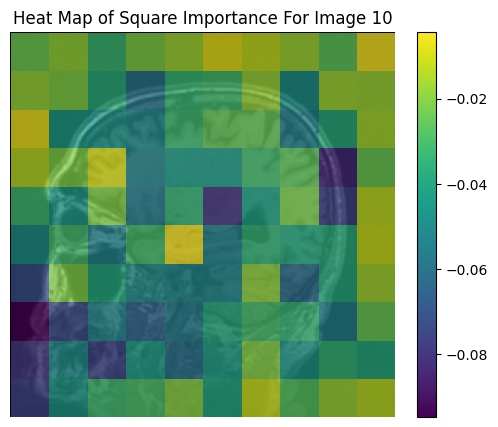

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the grayscale image
plt.figure(figsize=(7, 5))
path_10 = og_infos_df.loc[10]['File Path']
image_path = path_10
slice_10 = np.load(image_path)[:250, :250]

# Display the grayscale image
plt.imshow(slice_10, cmap='gray')
plt.axis('off')

# Set the size of the squares
square_size = 25
num_squares = 10  # 10 squares in total
# Loop to create and fill squares
for i in range(num_squares):
    for j in range(num_squares):
        # Create a rectangle (patch) for each square
        rect = patches.Rectangle((i * square_size, j * square_size), 
                                 square_size, square_size,
                                 linewidth=0,  # No border
                                 edgecolor='none', 
                                 facecolor=(rgb_values[j][i],.7))  # Solid fill color
        plt.gca().add_patch(rect)

cmap = plt.cm.viridis

# Normalize the original rgb_values for color mapping
norm = mcolors.Normalize(vmin=np.min(image_10), vmax=np.max(image_10))

mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(mappable, ax=plt.gca(), orientation='vertical', fraction=0.046, pad=0.04)

plt.title('Heat Map of Square Importance For Image 10')
plt.show()

okay we're gonnna do a bunch of them in one loop

In [99]:
nums = np.random.randint(0,1411,20)


In [105]:
nums

array([ 755,  469,   94, 1237,  385,  845,  679,  675,  570, 1245, 1355,
         40,  285,  974,  648,  409,   72,  297,  323,  468])

In [138]:
plt.figure(figsize=(10,20))
im


<Figure size 1000x2000 with 0 Axes>

In [139]:
n = 1
plt.figure(figsize=(10, 20))


<Figure size 1000x2000 with 0 Axes>

<Figure size 1000x2000 with 0 Axes>

In [ ]:
for num in nums:
    image = np.reshape(np.array([numb for numb in loss_calc_df.loc[num][window_cols]]), (10,10))
    normalized_data = (image - np.min(image)) / (np.max(image) - np.min(image))
    rgb_values = cmap(normalized_data)[:, :, :3]
    
    path = og_infos_df.loc[num]['File Path']
    image_path = path
    slice = np.load(image_path)[:250, :250]
    
    plt.subplot(10,2,n)
    n+=1
    
    im = plt.imshow(slice, cmap='gray')
    plt.axis('off')

    # Set the size of the squares
    square_size = 25
    num_squares = 10  # 10 squares in total
    # Loop to create and fill squares
    for i in range(num_squares):
        for j in range(num_squares):
            # Create a rectangle (patch) for each square
            rect = patches.Rectangle((i * square_size, j * square_size), 
                                 square_size, square_size,
                                 linewidth=0,  # No border
                                 edgecolor='none', 
                                 facecolor=(rgb_values[j][i],.7))  # Solid fill color
            plt.gca().add_patch(rect)

    cmap = plt.cm.viridis

    # Normalize the original rgb_values for color mapping
    norm = mcolors.Normalize(vmin=np.min(image), vmax=np.max(image))

    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    plt.colorbar(mappable, ax=plt.gca(), orientation='vertical', fraction=0.046, pad=0.04)

    #plt.title(f'Heat Map of Square Importance For Image {num}')
    #plt.savefig(f'Image {num} Heat Map')
    plt.show();